In [1]:
from entities import *
from constants import TEAMS_DATA, STAT_EFFECTS, POSSESSIONS_STD_DEV
from simulations import *

import pickle
import numpy as np
import pandas as pd

In [2]:
with open(TEAMS_DATA, 'rb') as f:
    teams = pickle.load(f)

with open(STAT_EFFECTS, 'rb') as f:
    stats = pickle.load(f)

In [3]:
test = simulate_n_games(teams['Kansas'], teams['Connecticut'], 500)

Simulating Game: Kansas vs. Connecticut


100%|██████████| 500/500 [00:11<00:00, 43.43it/s]

Kansas vs. Connecticut Complete!


In [4]:
test = simulate_n_games(teams['Portland'], teams['Portland State'], 500)

Simulating Game: Portland vs. Portland State


  0%|          | 0/500 [00:00<?, ?it/s]


AttributeError: 'Team' object has no attribute 'pace'

In [6]:
test['Record']

'Kansas: 239 - 261 :Connecticut'

In [7]:
test['Contributions']

,Team,2P,3P,BLK,STL,TOV,ORB,DRB,PF,Games Played
Darryn Peterson,Kansas,1033,774,170,427,341,0,854,256,159
Elmarko Jackson,Kansas,572,429,361,221,723,80,1226,1226,299
Flory Bidunga,Kansas,3113,0,1247,259,909,1351,3170,1195,387
Jamari McDowell,Kansas,69,778,147,420,504,147,1071,861,313
Tre White,Kansas,1349,677,205,307,1051,1154,2539,1308,381
Alec Millender,Connecticut,106,106,0,106,319,319,106,212,87
Eric Reibe,Connecticut,2751,210,912,210,561,982,2268,1473,347
Jaylin Stewart,Connecticut,974,587,386,515,644,515,2088,1314,383
Malachi Smith,Connecticut,721,640,71,498,712,356,997,784,354
Solomon Ball,Connecticut,1628,1119,158,449,793,396,1454,1057,393


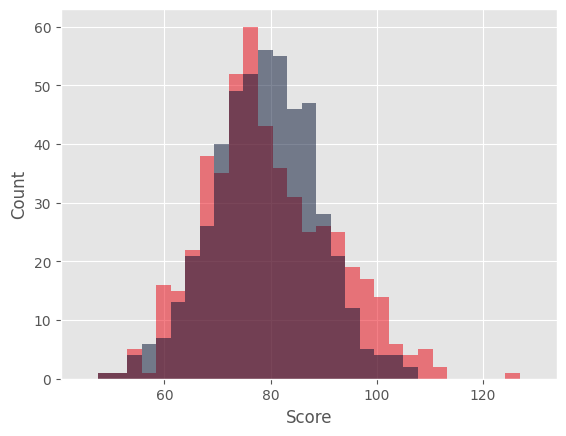

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('ggplot')

kansas = test['Scores']['Kansas']
uconn = test['Scores']['Connecticut']

min_score = min(kansas + uconn)
max_score = max(kansas + uconn)
bins = np.linspace(min_score-5, max_score+5, 32)

plt.hist(kansas, bins=bins, color='#e8000d', alpha=0.5)
plt.hist(uconn, bins=bins, color='#000E2F', alpha=0.5)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()